In [28]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

analisando frames: [0, 352, 634] de 705 totais


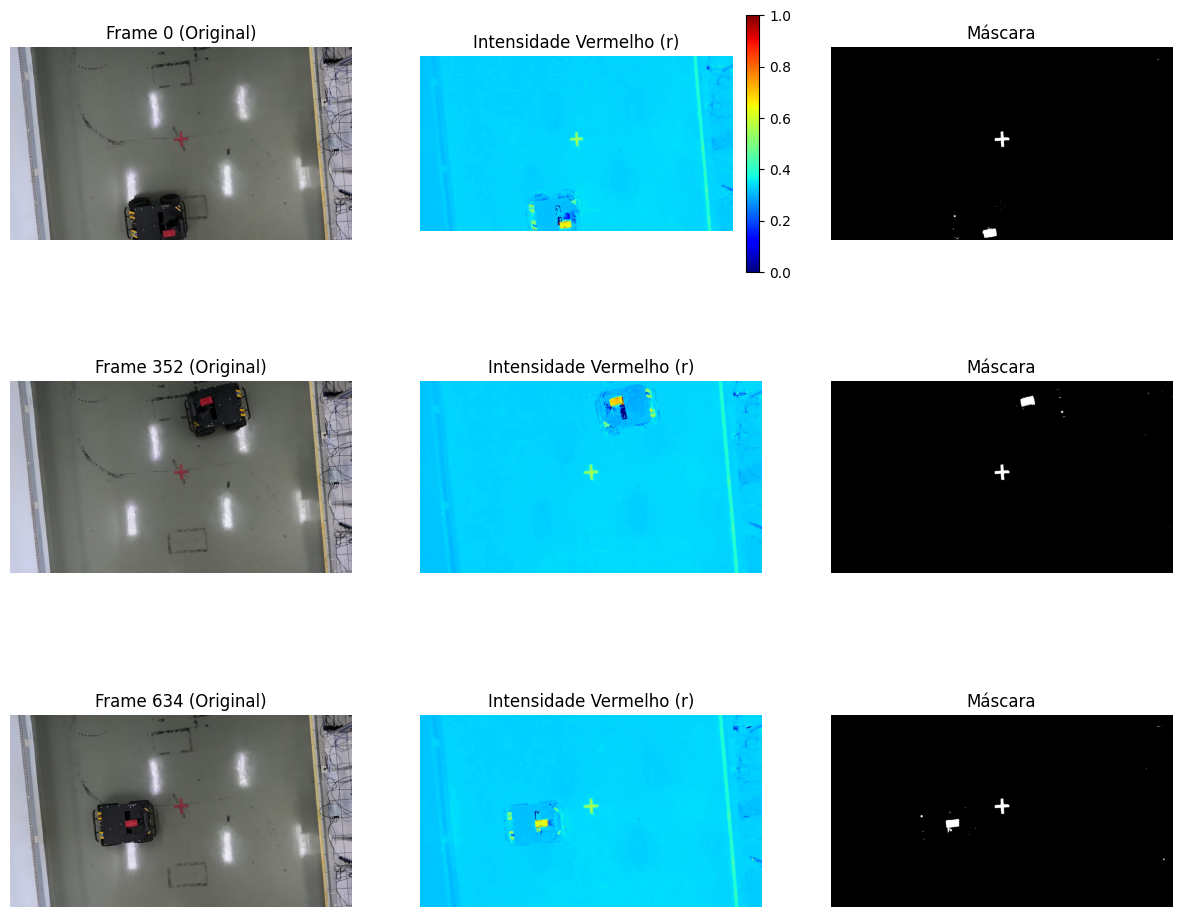

In [29]:
nome_video = 'video1.mp4'  
cap = cv.VideoCapture(nome_video)

if not cap.isOpened():
    print("eroo ao abrir o video")
else:
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) #vê todos os frames pra pegar amostras espalhadas
    
    indices_para_analisar = [0, int(total_frames * 0.5), int(total_frames * 0.9)] #pegando inicio meio e fim
    
    #apenas conguração do plot
    fig, axs = plt.subplots(len(indices_para_analisar), 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3) # Espaço entre as linhas

    print(f"analisando frames: {indices_para_analisar} de {total_frames} totais")

    for i, idx in enumerate(indices_para_analisar):
        #pula direto para o frame que se quer
        cap.set(cv.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB) #troca BGR por RGB por que o mathplotlib usa RGB e o opencv BGR
            img_float = frame_rgb.astype(np.float32) / 255.0
            soma = img_float.sum(axis=2) + 0.00000000000000001 #pra evitar divisao por zero
                                                                #a soma dos canais e a soma de R, G e B
            
            r = img_float[:,:,0] / soma
            g = img_float[:,:,1] / soma
            
            #definindo os limiares
            mask = (r > 0.4) & (g < 0.3) #BINARIZACAO
            mask_vis = mask.astype(np.uint8) * 255

            #configuracao da coluna 1 frame original
            axs[i, 0].imshow(frame_rgb)
            axs[i, 0].set_title(f"Frame {idx} (Original)")
            axs[i, 0].axis('off')
            
            #configuracao da coluna 2 mapa de calor para o vermelho
            im = axs[i, 1].imshow(r, cmap='jet', vmin=0, vmax=1)
            axs[i, 1].set_title("Intensidade Vermelho (r)")
            axs[i, 1].axis('off')
            # Adiciona barra de cor apenas na primeira linha para não poluir
            if i == 0: fig.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)

            #configuracao da coluna 3 máscara binária
            axs[i, 2].imshow(mask_vis, cmap='gray')
            axs[i, 2].set_title("Máscara")
            axs[i, 2].axis('off')
        else:
            print(f"erro ao ler frame {idx}")

    cap.release()
    plt.show()

considerando a boa definição apresentada, a cromaticidade pode ser utilizada mesmo considerando as pequenas variações do vermelho. Sob esse viés, quando o robô passar por áreas com maior ou menor iluminação (como o caso de sombras) não haverá problema.

### Seguindo a etapa 1 do README: Configuração da matriz

In [30]:
#colocando a matriz H que está no pdf. Essa matriz leva de mundo para imagem
H_pdf = np.array([ 
    [0.9236, 0, 1077.2023],
    [0, -0.9102, 1952.5904],
    [0, 0, 1]
])

#precisamos pegar o contrário da informação da matriz H, ou seja, precisamos fazer imagem -> mundo. (u,v) -> (X,Y)

H_inv = np.linalg.inv(H_pdf) #calculo a inversa da matriz H
print("matriz inversa calculada")
print(H_inv)


def pixel_para_mundo(u, v): #recebo as coordenadas em pixel e devolvo para milimetros
    ponto_img = np.array([u, v, 1]).reshape(3, 1)   #crio o vetor do ponto na imagem [u, v, 1], o reshape é para garantir que o vetor seja uma matriz coluna
                                                    #util e considerabevl ja que a matriz é 3x3
    # Aplica a transformação: P_mundo = H_inv * P_img
    ponto_mundo = np.dot(H_inv, ponto_img)#multiplico a matriz inversa pela matriz coluna do ponto na imagem
    
    if ponto_mundo[2] != 0: #normalização para o ultimo elemento ser 1
        X = ponto_mundo[0]/ponto_mundo[2]
        Y = ponto_mundo[1]/ponto_mundo[2]
        return float(X), float(Y)
    #return 0.0, 0.0

#resumo:
#1 - pego o pixel u,v
#2 - crio a matriz coluna [u,v,1]
#3 - multiplico pela matriz inversa H_inv
#4 - normalizo dividindo por ponto_mundo[2] que é W em [X,Y,W]
#testeando
x_teste, y_teste = pixel_para_mundo(320, 240)
print(f"\nTeste: Pixel (320, 240) corresponde a ({x_teste:.2f}, {y_teste:.2f}) no mundo.")

matriz inversa calculada
[[ 1.08271979e+00  0.00000000e+00 -1.16630825e+03]
 [-0.00000000e+00 -1.09865964e+00  2.14523226e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Teste: Pixel (320, 240) corresponde a (-819.84, 1881.55) no mundo.


C:\Users\ruano\AppData\Local\Temp\ipykernel_6976\1348091920.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(X), float(Y)


In [ ]:
def processar_frame(frame): #ESTUDOS DIRIGIDOS 8 E 9
    #Cromaticidade
    img_float = frame.astype(np.float32) / 255.0 #convertendo a imagem para float
    soma = img_float.sum(axis=2) + 0.00000000000000001 # Soma dos canais (+ pouquinho para não dividir por 0)
    
    r = img_float[:,:,2] / soma #normalizo o canal vermelho
    g = img_float[:,:,1] / soma #normalizo o canal verde

    mask = ((r > 0.4) & (g < 0.3)).astype(np.uint8) * 255 #denifo os limaires, ou seja, tem q ser um valor de vermelho alto e verde baixo
    

    #FORMAS DE OBEJTO
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
    #mask eh a imagem binaria onde quero achar os contornos que ja foi criada
    #cv.RETR_EXTERNAL pega apenas os contornos externos
    #cv.CHAIN_APPROX_SIMPLE é um metodo de compressão dos contornos
    
    dados = None
    
    if contours:
        c = max(contours, key=cv.contourArea) #procuro na lista de contornos qual tem a maior area, isso filtra os ruidos pequenos
        

        #REMOCAO DE RUIDO
        if cv.contourArea(c) > 50: #pego so com mais de 50 pixels de area tambem pra evitar ruidos
            #MOMENTOS
            M = cv.moments(c)
            if M['m00'] != 0: #verico por conta da divisao por zero
                u = int(M['m10']/M['m00'])
                v = int(M['m01']/M['m00'])
                
                #recupera os momentos centrais normalizados
                mu20 = M['mu20']/M['m00']
                mu02 = M['mu02']/M['m00']
                mu11 = M['mu11']/M['m00'] #covariancia
                
                #calcuando o angulo de inclicanao
                theta_rad = 0.5*np.arctan2(2*mu11, mu20-mu02)
                theta_graus = np.degrees(theta_rad)

                X, Y = pixel_para_mundo(u, v) #convertendo para as coordenadas do mundi
                
                # Agora salvamos o theta real em vez de 0
                dados = {'u': u, 'v': v, 'x_real': X, 'y_real': Y, 'theta': theta_graus}

                cv.circle(frame, (u, v), 15, (0, 0, 255), -1)
    return dados, frame

C:\Users\ruano\AppData\Local\Temp\ipykernel_6976\1348091920.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(X), float(Y)


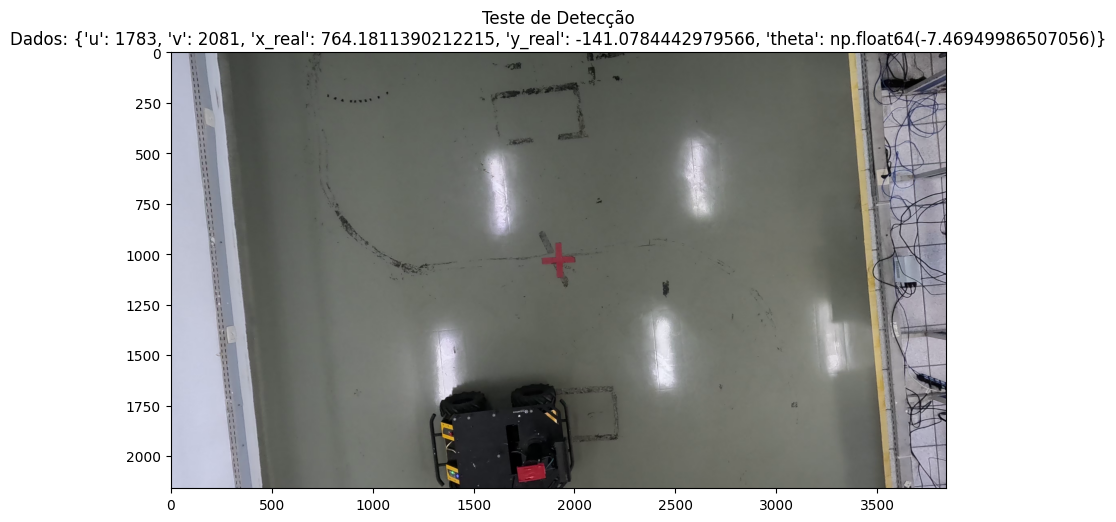

In [32]:
nome_video = 'video1.mp4'
cap = cv.VideoCapture(nome_video) #pego o video
ret, frame_teste = cap.read() #pego apenas um frame do video
cap.release() #como eu so que testar um frame, eu fecho o video

if ret:
    dados, imagem_processada = processar_frame(frame_teste)
    #lembrando:
    #dados: numeros posicao X, Y
    #imagem_processada: frame com o circulo desenhado se detectou algo

    plt.figure(figsize=(10, 8))
    plt.imshow(cv.cvtColor(imagem_processada, cv.COLOR_BGR2RGB))
    plt.title(f"Teste de Detecção\nDados: {dados}")
    #plt.axis('off')
    plt.show()
else:
    print("Erro ao ler o vídeo para teste.")

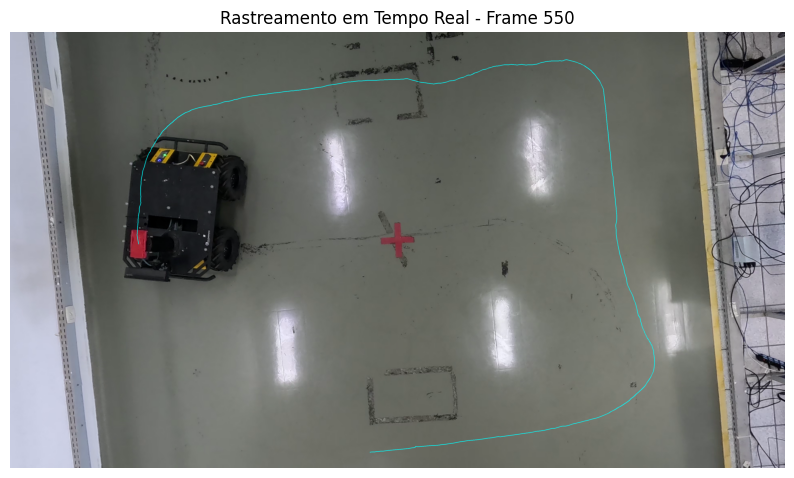

In [ ]:
# ==========================================
# 4. LOOP FINAL: PROCESSAMENTO E ANÁLISE
# ==========================================
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2 as cv
import numpy as np

# --- Configuração Inicial ---
# IMPORTANTE: Garanta que H_inv e pixel_para_mundo já foram definidos nas células anteriores!
# Substitua pelo nome do seu vídeo
video_path = 'video1.mp4' 
cap = cv.VideoCapture(video_path)

# Listas para guardar os dados da trajetória
traj_X = []      # Posição X no mundo (mm)
traj_Y = []      # Posição Y no mundo (mm)
traj_Theta = []  # Ângulo do robô (graus)
traj_u = []      # Pixel u (para desenho)
traj_v = []      # Pixel v (para desenho)

if not cap.isOpened():
    print(f"Erro: Não foi possível abrir '{video_path}'.")
else:
    print(f"Iniciando processamento de '{video_path}'...")

try:
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # --- O "Cérebro": Chama nossa função de processamento ---
        # Certifique-se de ter rodado a célula com 'def processar_frame' antes!
        dados, frame_desenhado = processar_frame(frame)
        
        if dados:
            # Se o robô foi detectado, guardamos os dados
            traj_u.append(dados['u'])
            traj_v.append(dados['v'])
            traj_X.append(dados['x_real'])
            traj_Y.append(dados['y_real'])
            traj_Theta.append(dados['theta'])
            
            # (Opcional) Desenhar o rastro da trajetória no vídeo
            if len(traj_u) > 1:
                # Converte listas de pontos para o formato que o OpenCV gosta
                pts = np.array(list(zip(traj_u, traj_v)), np.int32)
                # Desenha a linha da trajetória (ciano)
                cv.polylines(frame_desenhado, [pts], False, (255, 255, 0), 2)

        # --- Exibição Inteligente ---
        # Mostra apenas a cada 5 ou 10 frames para o notebook não travar/ficar lento
        if frame_count % 10 == 0:
            # Converter BGR (OpenCV) para RGB (Matplotlib)
            frame_rgb = cv.cvtColor(frame_desenhado, cv.COLOR_BGR2RGB)
            
            plt.figure(figsize=(10, 6))
            plt.imshow(frame_rgb)
            plt.title(f"Rastreamento em Tempo Real - Frame {frame_count}")
            plt.axis('off')
            plt.show()
            
            # Limpa a saída anterior para criar animação
            clear_output(wait=True)

except KeyboardInterrupt:
    print("Processamento interrompido pelo usuário.")

finally:
    cap.release()
    print("Vídeo finalizado.")

